## やること
- 4章でやったDoubry Robust法を、ランダムフォレストやmeta-learnersを用いて実行する

In [6]:
import random
import numpy as np
import pandas as pd

np.random.seed(1234)
random.seed(1234)

from numpy.random import *
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
from scipy.special import expit

plt.style.use('ggplot')

### データ生成

In [2]:
num_data = 200

# 年齢変数（15から76の一様乱数）
x_1 = randint(15, 76, num_data)

# 性別（1を男性）
x_2 = randint(0, 2, num_data)

# ノイズ
e_z = randn(num_data)

# シグモイド間数
z_base = x_1 + (1 - x_2)*10 - 40 + 5*e_z

# シグモイド関数を計算
z_prob = expit(0.1*z_base)

# テレビCMを見たかどうか
Z = np.array([])

# シグモイド関数からテレビを見たか確率計算して作る
for i in range(num_data):
    Z_i = np.random.choice(2, size = 1, p = [1 - z_prob[i], z_prob[i]])[0]
    Z = np.append(Z, Z_i)

In [3]:
# 購入量Yを定義
e_y = randn(num_data)

Y = -x_1 + 30*x_2 + 10*Z + 80 + 10*e_y

# データフレームで見る
df = pd.DataFrame({'age': x_1,
                   'sex': x_2,
                   'watch_cm': Z,
                   'purchase_amount': Y,
                   })

df.head()  # 先頭を表示

,age,sex,watch_cm,purchase_amount
0,62,0,1.0,24.464285
1,34,0,0.0,45.693411
2,53,1,1.0,64.998281
3,68,1,1.0,47.186898
4,27,1,0.0,100.114260


### Zの予測

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

x = df[['age', 'sex']]
z = df['watch_cm']

x_train, x_val, z_train, z_val = train_test_split(x, z, train_size = 0.6, random_state = 0)

for depth in range(1, 4):
    clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    clf.fit(x_train, z_train)
    print('木の深さ：', depth, '正解率：', clf.score(x_val, z_val))

木の深さ： 1 正解率： 0.85
木の深さ： 2 正解率： 0.85
木の深さ： 3 正解率： 0.825


### Yの予測

In [5]:
from sklearn.tree import DecisionTreeRegressor

x = df[['age', 'sex']]
y = df['purchase_amount']

x_train, x_val, y_train, y_val = train_test_split(x, y, train_size = 0.6, random_state = 0)

for depth in range(2, 5):
    clf = DecisionTreeRegressor(max_depth = depth, random_state = 0)
    clf.fit(x_train, y_train)
    print('木の深さ：', depth, '決定係数：', clf.score(x_val, y_val))

木の深さ： 2 決定係数： 0.7257496664596153
木の深さ： 3 決定係数： 0.7399348963931736
木の深さ： 4 決定係数： 0.7165539691159017


### meta-learnersの実装

In [8]:
# データ生成
num_data = 500

x = np.random.uniform(low = -1, high = 1, size = num_data) # -1~1の一様乱数

e_z = randn(num_data)
z_prob = expit(-1*-5.0*x + 5*e_z)
z = np.array([])

# zの作成
for i in range(num_data):
    z_i = np.random.choice(2, size=1, p=[1-z_prob[i], z_prob[i]])[0]
    z = np.append(z, z_i)

# 介入効果の非線形性
t = np.zeros(num_data)
for i in range(num_data):
    if x[i] < 0:
        t[i] = 0.5
    elif x[i] >= 0 and x[i] < 0.5:
        t[i] = 0.7
    elif x[i] >= 0.5:
        t[i] = 1.0

# yの生成
e_y = randn(num_data)
y = 2.0 + t*z + 0.3*x + 0.1*e_y
    

共変量がzとyの両方に影響し、yへの影響が非線形の場合を想定する

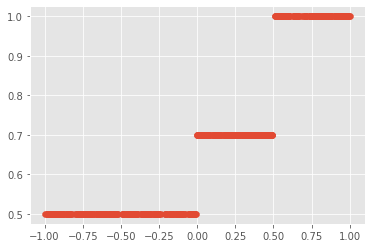

In [9]:
plt.scatter(x, t)

In [12]:
df = pd.DataFrame({'x': x,
                   'z': z,
                   't': t,
                   'y': y,
                   })

df.head()

,x,z,t,y
0,-0.616961,0.0,0.5,1.803183
1,0.244218,1.0,0.7,2.668873
2,-0.124545,0.0,0.5,2.193123
3,0.570717,1.0,1.0,3.245229
4,0.559952,1.0,1.0,3.139868


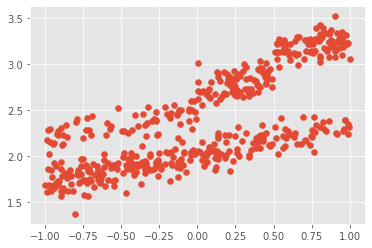

In [13]:
plt.scatter(x, y)

### t-learner
- 介入を受けていない集団と受けた集団のそれぞれについてyを推定するモデルを作る

In [21]:
# 集団の分割
df_z0 = df[df.z==0.0]
df_z1 = df[df.z==1.0]

# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor

reg_0 = RandomForestRegressor(max_depth=3)
reg_0.fit(df_z0['x'].values.reshape(-1, 1), df_z0['y'])

reg_1 = RandomForestRegressor(max_depth=3)
reg_1.fit(df_z1['x'].values.reshape(-1, 1), df_z1['y'])

RandomForestRegressor(max_depth=3)

In [25]:
# ATEを2つのモデルで求める
mu_0 = reg_0.predict(df['x'].values.reshape(-1, 1))
mu_1 = reg_1.predict(df['x'].values.reshape(-1, 1))

ATE = (mu_1 - mu_0).mean()
print('ATE:', ATE)

ATE: 0.6675451149102563


In [27]:
# 処置群における平均処置効果ATTと対照群における平均処置効果ATUを求める
ATT = df_z1['y'] - reg_0.predict(df_z1['x'].values.reshape(-1, 1))
ATU = reg_1.predict(df_z0['x'].values.reshape(-1, 1)) - df_z0['y']
print('ATT:', ATT.mean(), 'ATU:', ATU.mean())

ATT: 0.7349254122177318 ATU: 0.6065580517306569


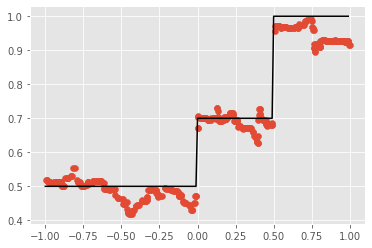

In [29]:
t_estimated = reg_1.predict(df['x'].values.reshape(-1, 1)) - reg_0.predict(df['x'].values.reshape(-1, 1))
plt.scatter(df['x'], t_estimated)

# 正解のグラフ
x_index = np.arange(-1, 1, 0.01)
t_ans = np.zeros(len(x_index))
for i in range(len(x_index)):
    if x_index[i] < 0:
        t_ans[i] = 0.5
    elif x_index[i] >= 0 and x_index[i] < 0.5:
        t_ans[i] = 0.7
    elif x_index[i] >= 0.5:
        t_ans[i] = 1.0

plt.plot(x_index, t_ans, color = 'black')

### s-learner
- 1つのモデルのみを用いて効果を推定する

In [30]:
# モデルの作成
reg = RandomForestRegressor(max_depth=4)
x = df.loc[:, ['x', 'z']]
reg.fit(x, df['y'])

RandomForestRegressor(max_depth=4)

In [31]:
# 処置が0の場合と1の場合両方を作成
x_0 = x.copy()
x_0['z'] = 0

x_1 = x.copy()
x_1['z'] = 1

# ATEの計算
ATE = (reg.predict(x_1) - reg.predict(x_0)).mean()
print('ATE:', ATE)

ATE: 0.6695558898304004


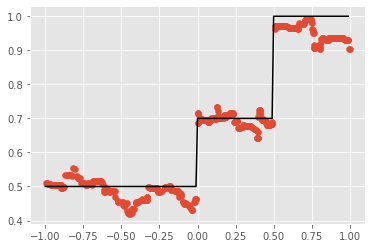

In [32]:
t_estimated = reg.predict(x_1) - reg.predict(x_0)
plt.scatter(df['x'], t_estimated)
plt.plot(x_index, t_ans, color = 'black')

### x-learner
- t-learnerの結果を傾向スコアを用いて補正する
- https://zenn.dev/s1ok69oo/articles/58580b8f4fbdf8

In [33]:
# 集団の分割
df_z0 = df[df.z==0.0] # 介入を受けてない集団
df_z1 = df[df.z==1.0] # 介入を受けた集団

# ランダムフォレスト
from sklearn.ensemble import RandomForestRegressor

m_0 = RandomForestRegressor(max_depth=3)
m_0.fit(df_z0['x'].values.reshape(-1, 1), df_z0['y'])

m_1 = RandomForestRegressor(max_depth=3)
m_1.fit(df_z1['x'].values.reshape(-1, 1), df_z1['y'])

RandomForestRegressor(max_depth=3)

In [34]:
# ATT, ATUを求める
atu = m_1.predict(df_z0['x'].values.reshape(-1, 1)) - df_z0['y']
att = df_z1['y'] - m_0.predict(df_z1['x'].values.reshape(-1, 1))

# 上の2つを求めるモデルを作成
m_2 = RandomForestRegressor(max_depth=3)
m_2.fit(df_z0['x'].values.reshape(-1, 1), atu)

m_3 = RandomForestRegressor(max_depth=3)
m_3.fit(df_z1['x'].values.reshape(-1, 1), att)

RandomForestRegressor(max_depth=3)

In [36]:
# 傾向スコアの算出
from sklearn.linear_model import LogisticRegression

x = df['x']
z = df['z']

g_x = LogisticRegression().fit(x.values.reshape(-1, 1), z)
g_x_val = g_x.predict_proba(x.values.reshape(-1, 1))

weighted_effect = g_x_val[:, 1]*m_2.predict(df['x'].values.reshape(-1, 1)) + g_x_val[:, 0]*m_3.predict(df['x'].values.reshape(-1, 1))

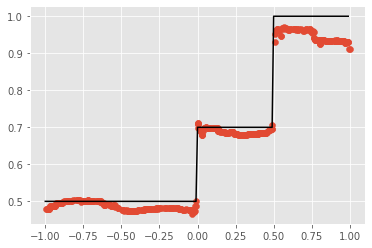

In [37]:
plt.scatter(df['x'], weighted_effect)
plt.plot(x_index, t_ans, color = 'black')

### Doubry Robust Learning

In [38]:
# ①T-Learnerの構築
# 集団の分割
df_z0 = df[df.z==0.0] # 介入を受けてない集団
df_z1 = df[df.z==1.0] # 介入を受けた集団

m_0 = RandomForestRegressor(max_depth=3)
m_0.fit(df_z0['x'].values.reshape(-1, 1), df_z0['y'])

m_1 = RandomForestRegressor(max_depth=3)
m_1.fit(df_z1['x'].values.reshape(-1, 1), df_z1['y'])

# ②傾向スコアの算出
x = df['x']
z = df['z']

g_x = LogisticRegression().fit(x.values.reshape(-1, 1), z)
g_x_val = g_x.predict_proba(x.values.reshape(-1, 1))

In [39]:
# 処置群
y_1 = m_1.predict(df_z1['x'].values.reshape(-1, 1)) \
    + (df_z1['y'] - m_1.predict(df_z1['x'].values.reshape(-1, 1)))/g_x.predict_proba(df_z1['x'].values.reshape(-1, 1))[:, 1]
df_z1['ite'] = y_1 - m_0.predict(df_z1['x'].values.reshape(-1, 1))

# 処置群
y_0 = m_0.predict(df_z0['x'].values.reshape(-1, 1)) \
    + (df_z0['y'] - m_0.predict(df_z0['x'].values.reshape(-1, 1)))/g_x.predict_proba(df_z0['x'].values.reshape(-1, 1))[:, 0]
df_z0['ite'] = m_1.predict(df_z0['x'].values.reshape(-1, 1)) - y_0

# 結合
df_dr = pd.concat([df_z0, df_z1])
df_dr.head()

/tmp/ipykernel_182/2501355129.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z1['ite'] = y_1 - m_0.predict(df_z1['x'].values.reshape(-1, 1))
/tmp/ipykernel_182/2501355129.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_z0['ite'] = m_1.predict(df_z0['x'].values.reshape(-1, 1)) - y_0


,x,z,t,y,ite
0,-0.616961,0.0,0.5,1.803183,0.506880
2,-0.124545,0.0,0.5,2.193123,0.086804
5,-0.454815,0.0,0.5,1.973293,0.319863
6,-0.447071,0.0,0.5,1.953387,0.349944
9,0.751865,0.0,1.0,2.289369,0.768703


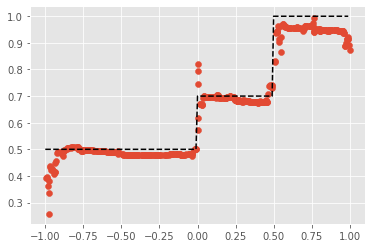

In [40]:
m_dr = RandomForestRegressor(max_depth=3)
m_dr.fit(df_dr['x'].values.reshape(-1, 1), df_dr['ite'])

t_estimated = m_dr.predict(df_dr['x'].values.reshape(-1, 1))

plt.scatter(df_dr['x'].values.reshape(-1, 1), t_estimated)
plt.plot(x_index, t_ans, color='black', ls='--', label='Baseline')